# Generating music

To generate music, I will use the **transformer** model, used by OpenAI in their GPT-2 model. In prior iterations, I had considered using RNNs with the seq2seq model. But after further research, I discovered that the transformer model can achieve better performance and accuracy, with the added benefit of parallelization, albeit at the cost of memory. 

In [50]:
import mido
import os
import math
import csv
import glob
import matplotlib.pyplot as plt
from itertools import chain, islice
from functools import cmp_to_key
from copy import deepcopy
from fractions import Fraction
import json
import pprint
import numpy as np
from collections import namedtuple

## Data Preparation

In [51]:
DATA_DIR = '../../data'

The Test Score: <br>
<img height=800 width=600 src="https://imslp.org/images/8/8b/TN-Schumann%2C_Robert_Werke_Breitkopf_Gregg_Serie_7_Band_2_RS_51_Op_13_scan.jpg"></img> <br>
Robert Schumann,Symphonic Etudes Op. 13 (with Posthumous variations)


In [52]:
# define function to play music
TEST_FILE = f'{DATA_DIR}/maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi'
def play_midi(file_name=TEST_FILE):
    os.startfile(os.path.abspath(file_name))

In [53]:
relevant_msgs = { 'note_on', 'note_off', 'control_change'}

is_note_on = lambda msg: msg.type == 'note_on' and msg.velocity > 0
is_note_off = lambda msg: (msg.type == 'note_on' and msg.velocity == 0) or msg.type == 'note_off'
is_relevant_msg = lambda msg: msg.type in relevant_msgs

In [54]:
def get_pitch(note: int):
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    return f"{notes[note % 12]}{note // 12 - 1}"

In [55]:
# make sure to iterate over tracks for correct deltatime value (ticks), otherwise deltatime is seconds. This is also faster.
def print_messages(track, limit: int=0, *, transnote=None, transvelocity=None, transtime=None):
    transnote = transnote or (lambda note: note) 
    transvelocity = transvelocity or (lambda velocity: velocity)
    transtime = transtime or (lambda time: time)
    track = islice(track, limit) if limit > 0 else track
    for event in track:
        if is_note_on(event):
            note, velocity, time = transnote(event.note), transvelocity(event.velocity), transtime(event.time)
            print(f'note_on channel={event.channel} note={note} velocity={velocity} time={time}')
        elif is_note_off(event):
            note, velocity, time = transnote(event.note), transvelocity(event.velocity), transtime(event.time)
            print(f'note_off channel={event.channel} note={note} time={time}')
        else:
            print(event)

In [56]:
schumann = mido.MidiFile(TEST_FILE)
for event in islice(schumann.tracks[1], 50):
    print(event)

program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=99 time=0
control_change channel=0 control=67 value=127 time=0
control_change channel=0 control=67 value=126 time=46
control_change channel=0 control=67 value=126 time=15
control_change channel=0 control=67 value=126 time=212
control_change channel=0 control=64 value=100 time=31
note_on channel=0 note=81 velocity=54 time=290
note_on channel=0 note=66 velocity=26 time=58
note_on channel=0 note=62 velocity=32 time=8
control_change channel=0 control=67 value=127 time=129
control_change channel=0 control=64 value=99 time=47
control_change channel=0 control=67 value=127 time=14
control_change channel=0 control=64 value=99 time=77
note_on channel=0 note=66 velocity=0 time=3
note_on channel=0 note=69 velocity=30 time=3
control_change channel=0 control=64 value=98 time=54
control_change channel=0 control=64 value=98 time=54
control_change channel=0 control=64 value=97 time=45
note_on channel=0 note=69 velocity=

In [57]:
schumann.ticks_per_beat

384

In [58]:
print_messages(schumann.tracks[1], 20, transnote=get_pitch)

program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=99 time=0
control_change channel=0 control=67 value=127 time=0
control_change channel=0 control=67 value=126 time=46
control_change channel=0 control=67 value=126 time=15
control_change channel=0 control=67 value=126 time=212
control_change channel=0 control=64 value=100 time=31
note_on channel=0 note=A5 velocity=54 time=290
note_on channel=0 note=F#4 velocity=26 time=58
note_on channel=0 note=D4 velocity=32 time=8
control_change channel=0 control=67 value=127 time=129
control_change channel=0 control=64 value=99 time=47
control_change channel=0 control=67 value=127 time=14
control_change channel=0 control=64 value=99 time=77
note_off channel=0 note=F#4 time=3
note_on channel=0 note=A4 velocity=30 time=3
control_change channel=0 control=64 value=98 time=54
control_change channel=0 control=64 value=98 time=54
control_change channel=0 control=64 value=97 time=45
note_off channel=0 note=A4 time=16


### Converting Ticks to Beats

Time attribute represents <deltatime\>. <deltatime\> is represented as number of ticks before playing the message. The number of ticks per beat is defined in the MThd chunk as <division\>. (i.e. <division\> = 96 means 96 ticks per beat). The number of microseconds per beat is defined as $500,000 \frac{\mu s}{beat}$, or can be set in the meta message 'set_tempo' in each track.

So $time = 288$, $division = 384$, $tempo = 500,000$ equates to $\frac{500,000}{384} * 288 = 375,000 \mu s$

This is the ticks between the first note_on (C#5) and the corresponding note off

This is equivalent to .375 seconds, which is the deltatime value when using `midi.play()` or `iter(midi)`



 With $500,000 \frac{\mu s}{beat}$, BPM = 120. The denominator of the time signature tells what kind of note (quarter, eighth) is a beat. The numerator tells how many beats are in bar. With a time signature of 4/4, a beat is a quarter note. 

With $time = 288$, and $division = 384$, $288 \ \text{ticks} * \frac{1}{384} \frac{beat}{tick} = .75 \ \text{beats}$

This is equal to $375,000 \mu s * \frac{1}{500000} \frac{beat}{\mu s} = .75 \ \text{beats}$.

A time signature of 4 means $time = 288$ is .75 of a quarter note. However, from the image above, the first notes are quarter notes, not fractions of quarter notes, probably because the performance was played with a different BPM in mind (Andante, maybe 90), and not the one given in the midi file. 


### Quantization

Quantize notes so that notes will have deltatime corrected to the nearest multiple of $\epsilon$. A lower $\epsilon$ means a higher frequency, but also more off-beats. A greater $\epsilon$ means lower frequency, and more synchronization.

In [59]:
BEAT_RESOLUTION = 16

In [60]:
def _nearest_mult(val, multiple):
    temp = val + multiple / 2
    return temp - temp % multiple

def quantize(sequence, ticks_per_beat: int, resolution: int, seqlen: int=None) -> np.ndarray:
    """
    takes in an iterable of integers and snaps values to the nearest resolution multiple,
    so that each value is replaced with an integer in the range [0, resolution)
    params:
      sequence: sequence of midi message objects to quantize
      ticks_per_beat: ticks per beat as given in midi metadata
      resolution: desired quantization resolution
      key: optional callable to be called on each element in the sequence before binning
    returns:
      sequence of integers with original values snapped to nearest multiple
    """
    seqlen = len(sequence) if seqlen is None else seqlen
    tick_res = ticks_per_beat / resolution

    quantized = (int(_nearest_mult(val, tick_res)) for val in sequence)
    return np.fromiter(quantized, dtype=np.int32, count=seqlen)

In [61]:
relevant_schumann = [msg for msg in schumann.tracks[1] if not msg.is_meta]
quantized = quantize(list(map(lambda msg: msg.time, relevant_schumann)), 
                     resolution=BEAT_RESOLUTION, 
                     ticks_per_beat=schumann.ticks_per_beat)
quantized_schumann = [msg.copy(time=new_time) for msg, new_time in zip(relevant_schumann, quantized)]
print_messages(quantized_schumann, 20, transnote=get_pitch)

program_change channel=0 program=0 time=0
control_change channel=0 control=64 value=99 time=0
control_change channel=0 control=67 value=127 time=0
control_change channel=0 control=67 value=126 time=48
control_change channel=0 control=67 value=126 time=24
control_change channel=0 control=67 value=126 time=216
control_change channel=0 control=64 value=100 time=24
note_on channel=0 note=A5 velocity=54 time=288
note_on channel=0 note=F#4 velocity=26 time=48
note_on channel=0 note=D4 velocity=32 time=0
control_change channel=0 control=67 value=127 time=120
control_change channel=0 control=64 value=99 time=48
control_change channel=0 control=67 value=127 time=24
control_change channel=0 control=64 value=99 time=72
note_off channel=0 note=F#4 time=0
note_on channel=0 note=A4 velocity=30 time=0
control_change channel=0 control=64 value=98 time=48
control_change channel=0 control=64 value=98 time=48
control_change channel=0 control=64 value=97 time=48
note_off channel=0 note=A4 time=24


In [62]:
schumann_copy = deepcopy(schumann)
schumann_copy.tracks[1] = mido.MidiTrack(quantized_schumann)
schumann_copy

<midi file '../../data/maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi' type 1, 2 tracks, 20827 messages>

In [63]:
schumann_copy.save('schumann.midi')

## Data Characteristics

In [64]:
MidiHeader = namedtuple('MidiHeader', ['format', 'ntrks', 'division'])

In [83]:
MTHD_MTRK = 4
CHUNK_LEN = 4
MTHD_DATA = 6

def get_header_data(midi_bytes: bytes):
    midi_bytes = midi_bytes[(MTHD_MTRK + MTHD_LEN):]
    midi_format = int.from_bytes(midi_bytes[0:2], 'big')
    midi_ntrks = int.from_bytes(midi_bytes[2:4], 'big')
    midi_division = int.from_bytes(midi_bytes[4:6], 'big')
    return MidiHeader(midi_format, midi_ntrks, midi_division)

In [84]:
midi_filenames = glob.glob(f'{DATA_DIR}/maestro-v3.0.0/[0-9]*/*')
raw_midi = []
for filename in midi_filenames:
    with open(filename, 'rb') as midi_fp:
        raw_midi.append(midi_fp.read())

In [85]:
midi_headers = [get_header_data(midi_data) for midi_data in raw_midi]

In [86]:
msg_lengths = [len(mido.MidiFile(filename).tracks[1]) for filename in glob.glob(f'{DATA_DIR}/maestro-v3.0.0/[0-9]*/*')]

In [90]:
print(f"""
all same format: {all(header.format == midi_headers[0].format for header in midi_headers)}
all same ntrks: {all(header.ntrks == midi_headers[0].ntrks for header in midi_headers)}
""")


all same format: True
all same ntrks: True




min: 924
max: 123539
25% quantile: 8281.25
median: 15208.0
75% quantile: 24962.75
average: 19799.486677115987



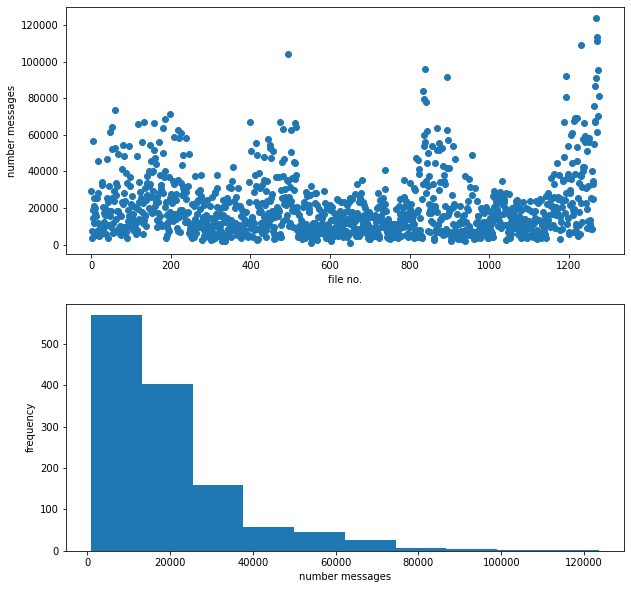

In [89]:
stats = f"""
min: {np.amin(msg_lengths)}
max: {np.amax(msg_lengths)}
25% quantile: {np.quantile(msg_lengths, 0.25)}
median: {np.quantile(msg_lengths, 0.5)}
75% quantile: {np.quantile(msg_lengths, 0.75)}
average: {np.mean(msg_lengths)}
"""
print(stats)
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
ax1.scatter(*zip(*enumerate(msg_lengths)))
ax1.set_xlabel("file no.")
ax1.set_ylabel("number messages")
ax2.hist(msg_lengths)
ax2.set_xlabel("number messages")
ax2.set_ylabel("frequency")
plt.show()

This will help in finding how to split training data for input and target sequences. Should I split at an arbitrary number of elements, or do a percentage split with padding to ensure both inputs and targets get adequate representation?

Because the minimum number of messages is ~900, I have to make sure that the straight split method reserves less than 900 for the input sequence, so that there is enough target data. 

I believe that an input size of slightly less than 900 will be fine for input length.

## Moving Away from Midi

In [ ]:
def rest(beats: int):
    return f'rest_b:{beats}'

def note(pitch: int, velocity: int, instrument: str='piano'):
    return f'note_p:{pitch}_v:{velocity}_i:{instrument}'

def control(control: int, value: int):
    return f'control_c:{control}_v:{value}'

MESSAGE_REF = {
  'note_on': note,
  'note_off': note,
  'control_change': control
}

def _get_message(msg):
    """
    constructs simple two byte messages (Control and Note). Doesn't 
    handle instruments. Doesn't handle note offs with non zero velocity
    """
    msg_data = msg.bytes()[1:]
    if msg.type == 'note_off':
        msg_data[-1] = 0
    msg_obj = MESSAGE_REF.get(msg.type, None)
    return msg_obj(*msg_data) if msg_obj is not None else msg_obj

### Converting to Notes

In [ ]:
def gen_messages(track, tick_per_beat, resolution):
    accum_time = 0
    for msg in track:
        accum_time += msg.time
        msg_obj = _get_message(msg)
        if msg_obj is not None:
            accum_beats = int(accum_time * resolution / tick_per_beat) # this eq can be factored into quantize method
            excess_beats = accum_beats % resolution
            for i in range(accum_beats // resolution):
                yield rest(resolution)
            if excess_beats != 0:
                yield rest(excess_beats)
            accum_time = 0
            yield msg_obj

def to_beats(track, tick_per_beat, resolution):
    return list(gen_messages(track, tick_per_beat, resolution))

In [ ]:
relevant_schumann_copy = [msg for msg in schumann_copy.tracks[1] if is_relevant_msg(msg)]
schumann_seq = to_beats(track=relevant_schumann_copy, resolution=16, tick_per_beat=schumann_copy.ticks_per_beat)
schumann_seq[:30]

The first value in each tuple represents the number of beats for that note is played. Because notes were quantized with a 64th note resolution and beats set to quarter notes, each note will have a time that is some multiple of $\frac{1}{16}$. 

> When quantizing, each tick value was adjusted so that $$\text{ticks}' = x * \frac{\text{ticks_per_beat}}{\text{resolution}}$$When converting to beats, $\text{ticks}'$ is divided by ticks_per_beat. $$\text{beats} = \frac{\text{ticks}'}{\text{ticks_per_beat}} = x * \frac{\text{ticks_per_beat}}{\text{resolution} * \text{ticks_per_beat}} = x * \frac{1}{\text{resolution}}$$

Using this approach, we will have 16 waits defined in the vocabulary (wait:[1-16]). Waits longer than 1 beat will be recorded as (wait:16, wait:n). However, a constant resolution needs to be set for all songs. Test quantizing a faster song.

### Binning velocities

In [ ]:
def _get_bin(value, bin_size: int, max_val: int, min_val: int) -> int:
    if value >= max_val:
        return bin_size + 1
    elif value < min_val:
        return 0
    else:
        return int((value - min_val) // bin_size) + 1

def bin_seq(sequence, num_bins: int, max_val: int, min_val: int, seqlen: int=None) -> np.ndarray:
    """
    takes in an iterable of numbers and assigns an integer label corresponding to the bin it falls
    in. Values greater than max_val are given a bin label of num_bins + 1, and values below min_val
    are given bin label 0.
    """
    bin_size = (max_val - min_val) / num_bins
    seqlen = len(sequence) if seqlen is None else seqlen

    binned = (_get_bin(val, bin_size, max_val, min_val) for val in sequence)
    return np.fromiter(binned, dtype=np.int32, count=seqlen)

In [ ]:
NUM_BINS = 32
MAX_VAL = 128
MIN_VAL = 1
BIN_SIZE = (MAX_VAL - MIN_VAL) / NUM_BINS
all_bins = [f'[{(i * BIN_SIZE) + MIN_VAL}, {(i * BIN_SIZE) + MIN_VAL + BIN_SIZE})' for i in range(32)]
schumann_to_bin = [msg for msg in relevant_schumann_copy if msg.type == 'note_on']
binned_schumann = bin_seq([msg.velocity for msg in schumann_to_bin], NUM_BINS, MAX_VAL, MIN_VAL)
zipped = zip(binned_schumann[:30], schumann_to_bin[:30])
print(f'max_val: {MAX_VAL}')
print(f'min_val: {MIN_VAL}')
print(f'num_bins: {NUM_BINS}')
print(f'bin_size: {BIN_SIZE}')
print('all_bins:')
for idx, row in enumerate(all_bins):
    print(f'\t{idx + 1}: {row}')
for row in zipped:
    print(row)

## Vocabulary

The full vocabulary will consist of 16 waits (or any power of 2 depending on what resolution I go with), and 128 notes, each with 32 volume levels, each with 6 instruments. A total size of 24,592.

Volumes will be binned for less noise, and to account for variability in performances.

For now I'll just stick with piano, so 88 notes (A0-C8), 32 volumes, 1 instrument, 16 waits. A total size of 2832. 

## Metadata + Features

### Additional Features

Aside from the vocabulary, I will train the model with the following features:

- [x] composer
- ~~key signature~~ (data not available)
- [x] tempo
- [x] time period/style


In [ ]:
with open(f'{DATA_DIR}/maestro-v3.0.0/maestro-v3.0.0.csv', encoding='utf-8') as csvfile:
    reader = list(csv.DictReader(csvfile))

In [ ]:
with open(f'{DATA_DIR}/metadata/composers.json') as composer_file:
    composers = json.load(composer_file)

For composer searching, I will need to clean up the csv file to make sure that composer names match up with the names given in the composers file.

### Epoch

In [ ]:
def epoch(complete_name: str):
    result = [composer for composer in composers if composer['complete_name'].lower() == complete_name.lower()]
    if len(result) > 0:
        return result[0]['epoch']
    return None

In [ ]:
epoch('Leoš Janáček')

### Composers

In [ ]:
# Unique Composers
unique_composers = set()
for row in reader:
    unique_composers.add(row['canonical_composer'])
unique_composers

There is a possibility of multiple composers. When this happens, choose the more common composer.

### CSV and Composer Cross Reference

In [ ]:
composers_both_present = dict()
for u_composer in unique_composers:
    split_composers = u_composer.split(' / ')
    for comp_name in split_composers:
        comp_entry = [entry for entry in composers if entry['complete_name'] == comp_name]
        comp_entry = comp_entry[0] if len(comp_entry) > 0 else None
        composers_both_present[comp_name] = comp_entry
pprint.pprint(composers_both_present)

In [ ]:
composers_not_present = [entry for entry in composers_both_present if composers_both_present[entry] is None]
print(f"Number not found in composer file: {len(composers_not_present)}")
composers_not_present

Some of these are surprising. For example Joseph Haydn is a very famous classical composer. Upon looking at the composers.json file, we can see that the names differ. Joseph Haydn is Joseph Franz Haydn in the composers.json file.

In [ ]:
approximate_composer_matches = dict()
for not_present in composers_not_present:
    last_name = not_present.split()[-1]
    comp_entry = [entry for entry in composers if last_name in entry['complete_name']]
    comp_entry = comp_entry[0] if len(comp_entry) > 0 else None
    approximate_composer_matches[not_present] = comp_entry
pprint.pprint(approximate_composer_matches)
print('\n')
print(f'composers still not present: {sorted([comp_name for comp_name, entry in approximate_composer_matches.items() if entry is None])}')

At the end of it all, there's still some missing composers, which we'll just label as 'Other.'

Let's also see some more metrics about composer **last names** in the `composers.json` file.

In [ ]:
unique_composers_in_json = set(comp['name'] for comp in composers)
all_lastnames_single_word = all(len(comp['name'].split()) == 0 for comp in composers)
print(f'All unique last names: {len(unique_composers_in_json) == len(composers)}')
print(f'All last names single word: {all_lastnames_single_word}')

Which last names aren't a single word?

In [ ]:
lastnames_multi_words = [comp['name'] for comp in composers if comp['name'].count(' ') != 0]
print(f'last names not single word: {lastnames_multi_words}')

## Test playback

In [ ]:
# Test playback original
play_midi()

In [ ]:
# Test playback quantized
play_midi('schumann.midi')